### Поиск клонов с помощью CodeBERT

Постановка и идея решения этой задачи не будет отличаться от предыдущей, где нужно было изучить представление кода через ```code2vec```. Здесь достаточно подменить способ получения эмбеддингов, теперь это будет ```CodeBERT```. Однако в прошлый раз вывод делался на основе игрушечного датасета, теперь будем использовать сниппеты кода из датасета [```POJ-104```](https://github.com/microsoft/CodeXGLUE/tree/main/Code-Code/Clone-detection-POJ-104). Скачать можно по ссылке.

In [1]:
import json, pathlib
import pandas as pd
import numpy as np

In [130]:
DATASET_PATH = pathlib.Path("dataset/poj_104.jsonl")

with open(DATASET_PATH, "r") as data:
    samples = [json.loads(line) for line in data.readlines()]

In [3]:
df = pd.DataFrame(samples).set_index("index")
df

,label,code
index,,
0,1,"int f(int n,int min){\n\tint i,result=1;\n\tif..."
1,1,"int fun(int m,int n)\n{\n int i,sum=1;\n ..."
2,1,/*\n * fenjie.cpp\n *\n * Created on: 2013-11...
3,1,"\nint f(int q,int x)\n{\n\tif(q<x)\n\t{\tint i..."
4,1,/************************************\n*??????...
...,...,...
31995,64,/*\n * jiegou_4.cpp\n * ???????\n * Created o...
31996,64,struct point{\n\tint x;\n\tint y;\n\tint z;\n}...
31997,64,int main()\n{\n int n;\n float distance[...


In [4]:
df.label.value_counts()

1     500
2     500
35    500
36    500
37    500
     ... 
27    500
28    500
29    500
30    500
64    500
Name: label, Length: 64, dtype: int64

Датасет ```POJ-104``` содержит $64$ типа задач вместо $3$ как для игрушечного датасета из прошлой задачи. Все классы изначально сбалансированны.

Теперь загрузим предтренированную модель ```CodeBERT```

In [5]:
import warnings, torch
warnings.filterwarnings("ignore")

from transformers import AutoTokenizer, AutoModel
from typing import Dict, Iterable

In [6]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

Поскольку максимальная длина последовательности для модели этой модели равняется $512$, нужно предварительно убрать все сниппеты кода, которые не удовлетворяют этому требованию и затем перебалансировать классы.

In [7]:
df.code.apply(lambda snippet: len(tokenizer.tokenize(snippet))).max()

Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


6831

Видно что такие снипетты в исходном датасете есть, удалим их и сделаем балансировку

In [8]:
df = df[df.apply(lambda x: len(tokenizer.tokenize(x["code"])) <= 512, axis = 1)]

Помотрим какая теперь максимальная длина после обработки токенизатором

In [9]:
df.code.apply(lambda snippet: len(tokenizer.tokenize(snippet))).max()

512

Но теперь классы не сбалансированны. Чтобы это исправить возьмем нижнюю границу на количество сниппетов, при этом допустимо потерять некоторое количество классов, потому что их итак много, плюс еще в том что не придется долго ждать пока посчитаются эмбеддинги

In [10]:
df.label.value_counts().values

array([500, 497, 494, 492, 490, 490, 490, 487, 487, 486, 485, 484, 482,
       482, 481, 481, 479, 479, 479, 475, 471, 471, 470, 466, 466, 464,
       462, 458, 454, 452, 449, 449, 449, 445, 444, 439, 430, 422, 418,
       413, 405, 405, 404, 399, 381, 379, 361, 330, 327, 317, 317, 305,
       299, 298, 292, 285, 264, 245, 208, 176, 172,  96,  33,  31])

In [11]:
from random import choices

BALANCE_LIMIT = 100

In [12]:
df["samples"] = df.code.apply(lambda x: [x])
df = df.groupby("label").agg({"samples": "sum"})

In [13]:
df = df[df.apply(lambda x: len(x["samples"]) >= BALANCE_LIMIT, axis = 1)]
df["samples"] = df.samples.apply(lambda samples: choices(samples, k = BALANCE_LIMIT))

In [14]:
all(df.samples.apply(lambda samples: len(samples) == BALANCE_LIMIT))

True

Все предобработки закончились. Теперь наконец получим эмбеддинги, при этом нужно как-нибудь понизить размерность и превратить контекстные эмбеддинги в один вектор. Например, через среднее.

In [15]:
from ipywidgets import IntProgress
from IPython.display import display

def create_context_embeddings(
    snippets: Iterable[str], max_context_size: int = 512, progress: bool = True) -> Iterable[np.array]:
    
    if progress:
        progress = IntProgress(min=0, max=len(snippets))
        display(progress)
    
    for snippet in snippets:
        code_tokens = tokenizer.tokenize(snippet)
        code_tokens +=  ["<pad>"] * (max_context_size - len(code_tokens))
        tokens = [tokenizer.cls_token] + code_tokens + [tokenizer.sep_token]
        tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
        
        try:
            context_embedding = model(torch.tensor(tokens_ids)[None,:])[0]
            if progress:
                progress.value += 1
            yield context_embedding.data.numpy()
        except IndexError as err:
            pass

In [16]:
dfs = []

progress = IntProgress(min=0, max=len(df))
display(progress)

for i in range(len(df)):
    label = int(df.iloc[i].name)
    context_embeddings = create_context_embeddings(df.iloc[i].samples, progress = False)
    vectors = [e.mean(axis=1).flatten().tolist() for e in context_embeddings]
    df_ = pd.DataFrame(data = vectors)
    df_["label"] = label
    dfs.append(df_)
    progress.value += 1
    
df = pd.concat(dfs).sample(frac = 1)
df.head()

IntProgress(value=0, max=61)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
15,-0.196263,-0.049859,0.206409,-0.048772,-0.800446,-0.332827,0.011412,-0.014319,0.293985,0.323533,...,-0.088394,-0.110172,0.580565,-0.204321,0.182299,0.632361,-0.910816,-0.376291,0.406403,37
74,-0.129188,-0.096691,0.181122,-0.069631,-0.813705,-0.374975,-0.036460,-0.060985,0.403051,0.311172,...,-0.099972,-0.088544,0.616600,-0.187726,0.155258,0.597850,-0.838422,-0.299632,0.384763,60
38,-0.236879,-0.035261,0.254429,0.144797,-0.491722,-0.145727,-0.016626,0.106858,0.293786,0.213029,...,-0.066183,-0.295650,0.461625,-0.267188,0.263288,0.670309,-0.898282,-0.373417,0.493581,2
88,-0.268591,0.051832,0.268689,0.160208,-0.912887,-0.410386,0.017543,0.012817,0.380688,0.371875,...,-0.067257,-0.234263,0.504040,-0.240615,0.209441,0.863482,-0.675945,-0.422101,0.514813,44
87,-0.091509,-0.051920,0.182499,-0.031158,-0.864953,-0.486916,-0.005217,0.024535,0.377353,0.329841,...,-0.026991,0.013709,0.772364,-0.157161,0.074932,0.578580,-0.775771,-0.256345,0.393357,54


In [17]:
df.label.value_counts()

50    100
28    100
16    100
34    100
36    100
     ... 
5      99
8      98
14     98
32     98
27     97
Name: label, Length: 61, dtype: int64

Перейдем к классификации

In [117]:
df = pd.concat(dfs).sample(frac = 1)

In [118]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(
    n_neighbors = 5,
    metric = "cosine"
)

In [119]:
X = df.drop(["label"], axis = 1).values
y = df["label"].values

X.shape, y.shape

((6086, 768), (6086,))

In [120]:
from sklearn.metrics import accuracy_score, classification_report

clf = clf.fit(X, y)
y_pred = clf.predict(X)

accuracy_score(y, y_pred)

0.566053236937233

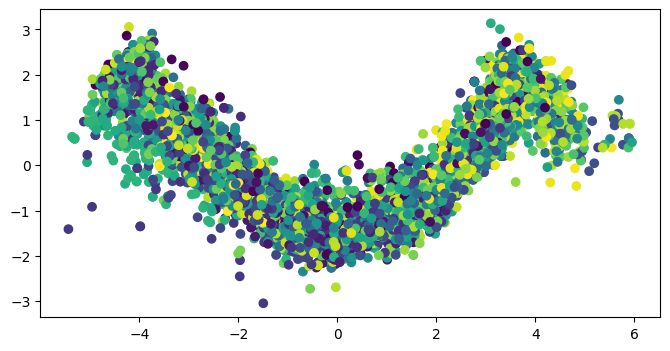

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2'])
df_pca['y'] = y

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(df_pca.PC1, df_pca.PC2, c = df_pca.y)

plt.show()

Слишком много типов задач для такого простого классификатора, в котором обучения то по сути и нет, вместо этого хочется просто разделить эмбеддинги по выбранной метрике. И это логично что разделить качественно в этом случае с этим классификатором не получается.

In [133]:
df_quarter = df[df.label.isin(df.label.unique()[:len(df.label.unique())//4])]

In [134]:
X = df_quarter.drop(["label"], axis = 1).values
y = df_quarter["label"].values

clf = clf.fit(X, y)
y_pred = clf.predict(X)

accuracy_score(y, y_pred)

0.6818181818181818

С меньшим числом классов тот же классификатор дал лучше скор. Ожидаемо. Возьмем еще меньше

In [147]:
df_small = df[df.label.isin(df.label.unique()[:3])]

In [148]:
X = df_small.drop(["label"], axis = 1).values
y = df_small["label"].values

clf = clf.fit(X, y)
y_pred = clf.predict(X)

accuracy_score(y, y_pred)

0.8766666666666667

Давайте $N$ раз будем рандомно выбирать маленький фрейм и смотреть скор

In [152]:
import random

N = 1000
scores = []

for i in range(N):
    df_small = df[df.label.isin(random.choices(df.label.unique(), k = 3))]

    X = df_small.drop(["label"], axis = 1).values
    y = df_small["label"].values

    clf = clf.fit(X, y)
    y_pred = clf.predict(X)

    scores.append(accuracy_score(y, y_pred))

In [153]:
pd.Series(scores).describe()

count    1000.000000
mean        0.870048
std         0.056836
min         0.643333
25%         0.833333
50%         0.873333
75%         0.910000
max         1.000000
dtype: float64

В среднем получался скор на уровне игрушечного датасета из предыдущей задачи. Простой классификатор не смог в лоб решить задачу для большого количества классов, однако разные комбинации небольших размеров он хорошо отделил друг от друга. Это более сильное условие, проверенное с помощью более масштабного датасета. Таким образом **можно сделать вывод о том, что модель** ```CodeBERT``` **годится для получения эмбеддингов, различая функциональные свойства разных сниппетов кода**. 